In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

2022-10-22 14:56:34.958576: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_dir = r"../Shashank/dataset/ImageEmotion (85-15)/train"
test_dir = r"../Shashank/dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [3]:
#preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rotation_range= 10,
                                   validation_split = 0
                                  )
test_datagen = ImageDataGenerator(validation_split = 0
                                  )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [7]:
emotion_model1 = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')
emotion_model2 = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

preprocess_fn1 = tf.keras.applications.densenet.preprocess_input 
preprocess_fn2 = tf.keras.applications.resnet.preprocess_input 

def emotion_model1_feature_extractor(inputs):
    y = emotion_model1(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def emotion_model2_feature_extractor(inputs):
    y = emotion_model2(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model1, emotion_model2):
    x, emotion_features1 = emotion_model1(preprocess_fn1(inputs)*1./255)
    x, emotion_features2 = emotion_model2(preprocess_fn2(inputs)*1./255)
    
    merged_emotion_features = tf.concat([emotion_features1, emotion_features2], axis=1)
    classification_output = classifier(merged_emotion_features)
    
    return classification_output, merged_emotion_features

def define_compile_model(emotionweights1_path, emotionweights2_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model1 = tf.keras.Model(inputs= inputs, outputs= emotion_model1_feature_extractor(inputs))
    emotion_model1.load_weights(emotionweights1_path)
    emotion_model2 = tf.keras.Model(inputs= inputs, outputs= emotion_model2_feature_extractor(inputs))
    emotion_model2.load_weights(emotionweights2_path)
    
    classification_output,merged_emotion_features = final_model(inputs, emotion_model1, emotion_model2) 
    model = tf.keras.Model(inputs= inputs, outputs= [classification_output, merged_emotion_features])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [8]:
emotionweights1_path = r'../Shashank/h5 files/DenseNet201-010-0.780538-0.641440.h5'
emotionweights2_path = r'../Shashank/h5 files/ResNet101-009-0.762864-0.650595.h5'
model = define_compile_model(emotionweights1_path, emotionweights2_path)
model.load_weights(r'Idea4_DenseNet201+ResNet101_100-008-0.781723-0.667074.h5')

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_4 (TFOpLambda)  (None, 224, 224, 3)  0          ['input_8[0][0]']                
                                                                                                  
 tf.nn.bias_add_2 (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv_4[0][0]']      
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 224, 224, 3)  0          ['input_8[0][0]']          

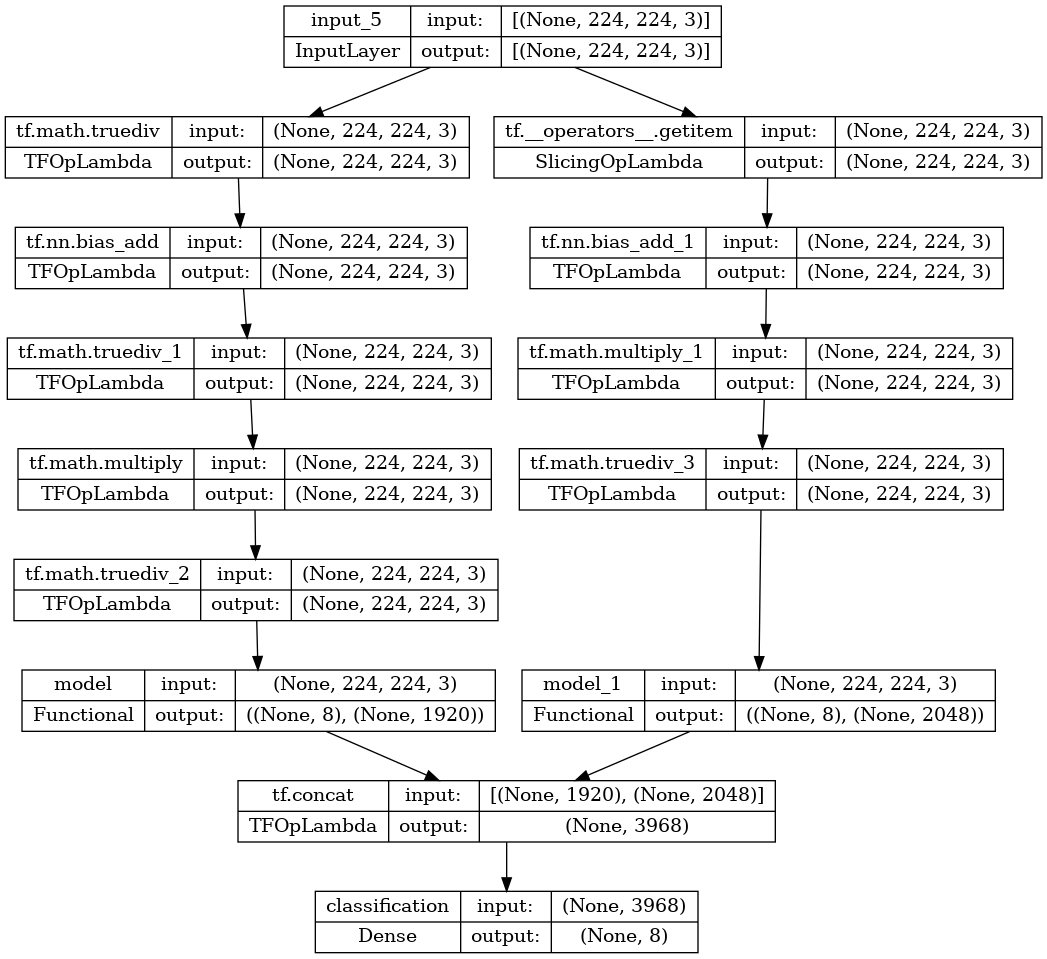

In [8]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [9]:
#for saving weights after every epoch
checkpoint = ModelCheckpoint('Idea4_DenseNet201+ResNet101_100-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                        monitor='val_acc',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [10]:
#training the model
history = model.fit(train_generator,
            batch_size = BATCH_SIZE,
            epochs= 100,
            validation_data = test_generator,
            callbacks= [checkpoint]
            ) 

history = pd.DataFrame(history.history)

Epoch 1/100
290/290 [==============================] - ETA: 0s - loss: 1.3284 - acc: 0.5344 
Epoch 1: val_acc improved from -inf to 0.59628, saving model to Idea4_DenseNet201+ResNet101_100-001-0.534404-0.596277.h5
290/290 [==============================] - 3140s 11s/step - loss: 1.3284 - acc: 0.5344 - val_loss: 1.1651 - val_acc: 0.5963
Epoch 2/100
290/290 [==============================] - ETA: 0s - loss: 0.9404 - acc: 0.6703 
Epoch 2: val_acc improved from 0.59628 to 0.63259, saving model to Idea4_DenseNet201+ResNet101_100-002-0.670349-0.632591.h5
290/290 [==============================] - 3099s 11s/step - loss: 0.9404 - acc: 0.6703 - val_loss: 1.0775 - val_acc: 0.6326
Epoch 3/100
290/290 [==============================] - ETA: 0s - loss: 0.8387 - acc: 0.7077 
Epoch 3: val_acc improved from 0.63259 to 0.64175, saving model to Idea4_DenseNet201+ResNet101_100-003-0.707743-0.641746.h5
290/290 [==============================] - 3093s 11s/step - loss: 0.8387 - acc: 0.7077 - val_loss: 1.050

KeyboardInterrupt: 

In [9]:
json_model = model.to_json()
with open('Idea4_DenseNet201+ResNet101_100.json', 'w') as json_file:
    json_file.write(json_model)
print('Saved model.')

Saved model.
